
# Carbon Intensity (UK) – Exploratory Analysis

**Goal:** fetch UK electricity carbon intensity data, tidy it, and explore basic patterns.

**Data Source:** National Grid ESO / UK Carbon Intensity API – <https://api.carbonintensity.org.uk/>

> Tip: All timestamps are handled as UTC here. You can convert to Europe/London if desired.


In [2]:
%pip install -r ../requirements.txt


   ------------------------------ --------- 3/4 [isoduration]
   ---------------------------------------- 4/4 [isoduration]

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip list

Package                           Version
--------------------------------- -------------------
aext-assistant                    4.20.0
aext-assistant-server             4.20.0
aext-core                         4.20.0
aext-core-server                  4.20.0
aext_environments_server          4.20.0
aext-panels                       4.20.0
aext-panels-server                4.20.0
aext-project-filebrowser-server   4.20.0
aext-share-notebook               4.20.0
aext-share-notebook-server        4.20.0
aext-shared                       4.20.0
aext-toolbox                      4.20.0
aiobotocore                       2.19.0
aiohappyeyeballs                  2.4.4
aiohttp                           3.11.10
aioitertools                      0.7.1
aiosignal                         1.2.0
alabaster                         0.7.16
alembic                           1.16.2
altair                            5.5.0
anaconda-anon-usage               0.7.1
anaconda-auth                     0.8.6
anacond

In [4]:
!python ../scripts/fetch_ci.py --days 30

Fetching UK carbon intensity from 2025-08-22 11:00:00+00:00 to 2025-09-21 11:00:00+00:00 (UTC) ...
Saved raw JSON: data/raw/uk_ci_raw_20250921T114704Z.json
Saved processed CSV: data/processed/uk_ci_processed_20250921T114704Z.csv
Done.


In [8]:
%ls data\processed

 Volume in drive C is Windows
 Volume Serial Number is C089-D380

 Directory of C:\Users\HP\OneDrive\GitHub\carbon-intensity-analysis\notebooks\data\processed

21/09/2025  12:47    <DIR>          .
21/09/2025  12:47    <DIR>          ..
21/09/2025  12:47            95,102 uk_ci_processed_20250921T114704Z.csv
               1 File(s)         95,102 bytes
               2 Dir(s)  66,840,100,864 bytes free


In [7]:
!dir ..\data\processed

 Volume in drive C is Windows
 Volume Serial Number is C089-D380

 Directory of C:\Users\HP\OneDrive\GitHub\carbon-intensity-analysis\data\processed

21/09/2025  12:29    <DIR>          .
21/09/2025  12:29    <DIR>          ..
21/09/2025  12:29                 0 .gitkeep
               1 File(s)              0 bytes
               2 Dir(s)  66,847,420,416 bytes free


In [9]:

# Imports
import os
import json
from datetime import datetime, timedelta, timezone

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 10)
pd.set_option("display.width", 120)


In [10]:

# Helper to load the latest processed CSV (from scripts/fetch_ci.py)
from glob import glob

processed = sorted(glob("data/processed/uk_ci_processed_*.csv"))
if not processed:
    print("No processed CSV found. Run the fetcher first, e.g.:")
    print("  python scripts/fetch_ci.py --days 30")
else:
    latest_csv = processed[-1]
    print("Using:", latest_csv)
    df = pd.read_csv(latest_csv, parse_dates=["from_utc","to_utc"])
    df.head()


Using: data/processed\uk_ci_processed_20250921T114704Z.csv


In [11]:
from IPython.display import display
# basic checks
print("shape:", df.shape)
display(df.head(10))
df.info()

shape: (1441, 5)


,from_utc,to_utc,forecast_gco2_per_kwh,actual_gco2_per_kwh,index_label
0,2025-08-22 10:30:00+00:00,2025-08-22 11:00:00+00:00,139,138,moderate
1,2025-08-22 11:00:00+00:00,2025-08-22 11:30:00+00:00,141,143,moderate
2,2025-08-22 11:30:00+00:00,2025-08-22 12:00:00+00:00,137,142,moderate
3,2025-08-22 12:00:00+00:00,2025-08-22 12:30:00+00:00,137,138,moderate
4,2025-08-22 12:30:00+00:00,2025-08-22 13:00:00+00:00,139,133,moderate
5,2025-08-22 13:00:00+00:00,2025-08-22 13:30:00+00:00,140,130,moderate
6,2025-08-22 13:30:00+00:00,2025-08-22 14:00:00+00:00,133,131,moderate
7,2025-08-22 14:00:00+00:00,2025-08-22 14:30:00+00:00,139,135,moderate
8,2025-08-22 14:30:00+00:00,2025-08-22 15:00:00+00:00,139,139,moderate
9,2025-08-22 15:00:00+00:00,2025-08-22 15:30:00+00:00,146,149,moderate


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1441 entries, 0 to 1440
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   from_utc               1441 non-null   datetime64[ns, UTC]
 1   to_utc                 1441 non-null   datetime64[ns, UTC]
 2   forecast_gco2_per_kwh  1441 non-null   int64              
 3   actual_gco2_per_kwh    1441 non-null   int64              
 4   index_label            1441 non-null   object             
dtypes: datetime64[ns, UTC](2), int64(2), object(1)
memory usage: 56.4+ KB


In [13]:

# Basic sanity checks (only runs if df exists in scope)
try:
    print("Rows:", len(df))
    print("Columns:", list(df.columns))
    from IPython.display import display
    display(df.describe(include="all"))
except NameError:
    pass


Rows: 1441
Columns: ['from_utc', 'to_utc', 'forecast_gco2_per_kwh', 'actual_gco2_per_kwh', 'index_label']


,from_utc,to_utc,forecast_gco2_per_kwh,actual_gco2_per_kwh,index_label
count,1441,1441,1441.000000,1441.000000,1441
unique,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,low
freq,NaN,NaN,NaN,NaN,784
mean,2025-09-06 10:30:00.000000256+00:00,2025-09-06 11:00:00+00:00,101.764747,101.717557,NaN
...,...,...,...,...,...
25%,2025-08-29 22:30:00+00:00,2025-08-29 23:00:00+00:00,62.000000,65.000000,NaN
50%,2025-09-06 10:30:00+00:00,2025-09-06 11:00:00+00:00,92.000000,90.000000,NaN
75%,2025-09-13 22:30:00+00:00,2025-09-13 23:00:00+00:00,137.000000,136.000000,NaN
max,2025-09-21 10:30:00+00:00,2025-09-21 11:00:00+00:00,222.000000,211.000000,NaN



## 1) Time-series overview
Compute daily averages and a 7-day rolling mean to highlight trends.


In [15]:
print(df[["forecast_gco2_per_kwh","actual_gco2_per_kwh"]].dtypes)
print(df[["forecast_gco2_per_kwh","actual_gco2_per_kwh"]].head(3))
print("NaNs in actual:", df["actual_gco2_per_kwh"].isna().sum())
print("NaNs in forecast:", df["forecast_gco2_per_kwh"].isna().sum())


forecast_gco2_per_kwh    int64
actual_gco2_per_kwh      int64
dtype: object
   forecast_gco2_per_kwh  actual_gco2_per_kwh
0                    139                  138
1                    141                  143
2                    137                  142
NaNs in actual: 0
NaNs in forecast: 0


ci len: 1441 min/max: 34.0 211.0
any NaN? False


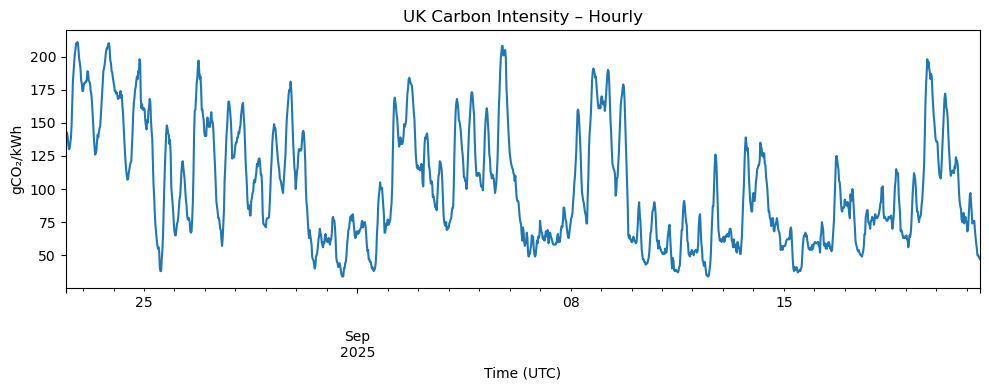

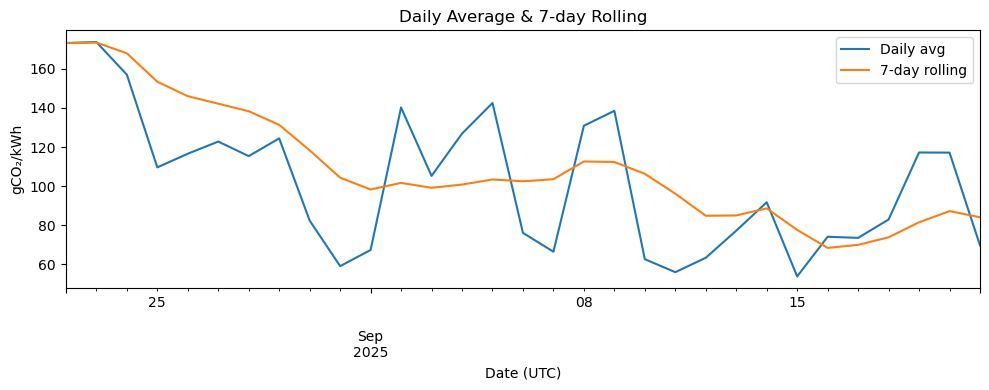

In [23]:
# 1) make sure timestamps are datetime and sorted
df["from_utc"] = pd.to_datetime(df["from_utc"], utc=True, errors="coerce")
df["to_utc"]   = pd.to_datetime(df["to_utc"],   utc=True, errors="coerce")
df = df.sort_values("from_utc").reset_index(drop=True)

# 2) pick actual where available, else forecast
ci = df["actual_gco2_per_kwh"].copy()
ci = ci.fillna(df["forecast_gco2_per_kwh"])

# quick checks
print("ci len:", len(ci), "min/max:", float(ci.min()), float(ci.max()))
print("any NaN?", ci.isna().any())

# 3) build time series with aligned index (by position)
ts = pd.Series(ci.values, index=df["from_utc"], name="ci")

# 4) plot hourly
plt.figure(figsize=(10,4))
ts.plot()
plt.title("UK Carbon Intensity – Hourly")
plt.xlabel("Time (UTC)")
plt.ylabel("gCO₂/kWh")
plt.tight_layout()
plt.show()

# 5) plot daily avg + 7d rolling
daily = ts.resample("D").mean()
roll7 = daily.rolling(7, min_periods=1).mean()

plt.figure(figsize=(10,4))
daily.plot(label="Daily avg")
roll7.plot(label="7-day rolling")
plt.title("Daily Average & 7-day Rolling")
plt.xlabel("Date (UTC)")
plt.ylabel("gCO₂/kWh")
plt.legend()
plt.tight_layout()
plt.savefig("../figures/daily_trend.png", dpi=200, bbox_inches="tight")
plt.show()





## 2) Hour-of-day profile
Average carbon intensity by hour (across the loaded period).


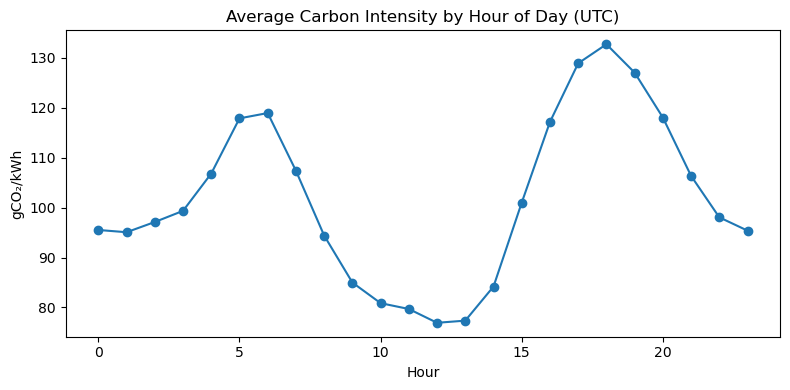

In [24]:
# Make sure we have a single CI column to use
df["ci"] = df["actual_gco2_per_kwh"].fillna(df["forecast_gco2_per_kwh"])

# Group by hour-of-day using the datetime column (no index tricks)
hod = df.groupby(df["from_utc"].dt.hour)["ci"].mean().sort_index()

plt.figure(figsize=(8,4))
hod.plot(marker="o")
plt.title("Average Carbon Intensity by Hour of Day (UTC)")
plt.xlabel("Hour")
plt.ylabel("gCO₂/kWh")
plt.tight_layout()
plt.savefig("../figures/hour_of_day.png", dpi=200, bbox_inches="tight")
plt.show()





## 3) (Optional) Calendar heatmap: day vs hour
This shows within-day patterns across multiple days. We'll use pure Matplotlib.


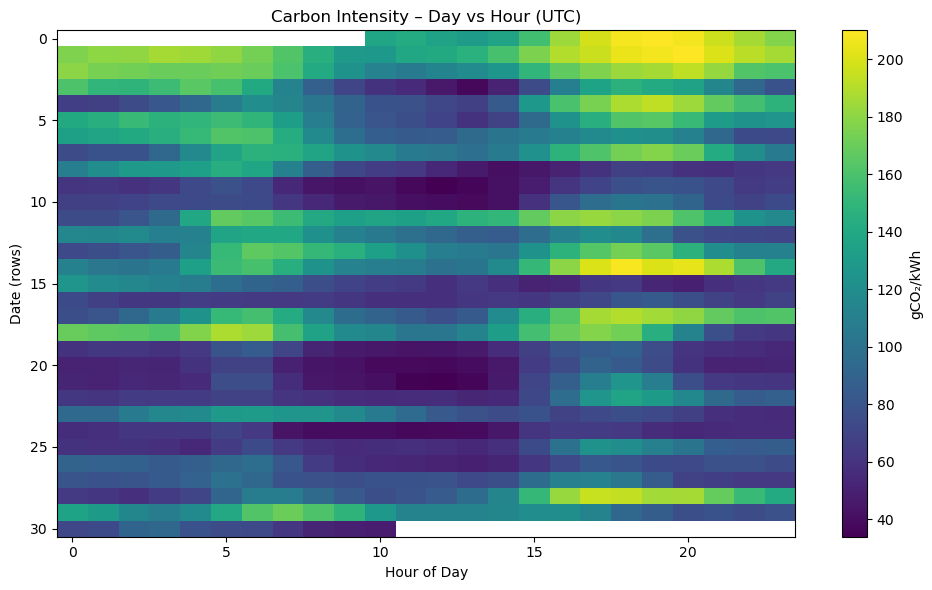

In [25]:
wide = df.loc[:, ["from_utc", "ci"]].copy()
wide["date"] = wide["from_utc"].dt.date
wide["hour"] = wide["from_utc"].dt.hour
pivot = wide.pivot_table(index="date", columns="hour", values="ci", aggfunc="mean")

plt.figure(figsize=(10,6))
plt.imshow(pivot.values, aspect="auto")
plt.title("Carbon Intensity – Day vs Hour (UTC)")
plt.xlabel("Hour of Day")
plt.ylabel("Date (rows)")
plt.colorbar(label="gCO₂/kWh")
plt.tight_layout()
plt.savefig("../figures/calendar_heatmap.png", dpi=200, bbox_inches="tight")
plt.show()
